<a href="https://colab.research.google.com/github/ninavergara605/dimension_analysis/blob/master/box_counting_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import scipy
import pandas as pd
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [ ]:
from google.colab import files
import io

uploaded = files.upload()
nodes = pd.read_csv(io.BytesIO(uploaded['koch_curve.csv'])).values

Saving koch_curve.csv to koch_curve (3).csv


### Initializing Test Data

In [ ]:
nodes_df = pd.Series(nodes.flatten()).str.split(" ", expand=True).apply(pd.to_numeric, errors='ignore')
path = nodes_df.values[:100]
nodes = path

In [ ]:
# Initialize test points for analysis
'''nodes = np.array([
        (0,1)
        ,(2,4)
        ,(6,10)
        ,(15,6)
])'''

# Interpolates X and Y values for a node and the following node to yeild one continuous line 
lines_x = [np.linspace(x0,x1) for (x0,x1) in zip(nodes[:-1,0], nodes[1:,0])]
lines_y = [np.linspace(y0,y1) for (y0,y1) in zip(nodes[:-1,1], nodes[1:,1])]

# Concatenates the X and Y lines and pairs them into points
path =  np.array(list(zip(np.array(lines_x).flatten(), np.array(lines_y).flatten())))
path[:5]

array([[0.09144947, 0.        ],
       [0.09238263, 0.00161628],
       [0.09331579, 0.00323255],
       [0.09424895, 0.00484883],
       [0.09518211, 0.00646511]])

## Implementation Walkthrough

### Creating the Initial Grid

In [ ]:
# To determine the maximum x and y axis values of the grid, one is added to the largest x and y point value.
grid_dim = [max(nodes[:,0])+1, max(nodes[:,1])+1]

# In this example, the grid is split into 5 segments on both the x and y axis.
nboxes = 4
n_divides = int(np.sqrt(nboxes))
# np.linspace is used to mark the segment intercept points for each axis of the grid
grid_x, grid_y = np.linspace(0, grid_dim[0],num=n_divides+1), np.linspace(0, grid_dim[1],num=n_divides+1)
print(grid_x, grid_y)

[0.         1.94032922 3.88065844] [0.         1.25237689 2.50475379]


In [ ]:
def divide_segment(segment):
  divided = []
  for i in range(len(segment)-1):
    lower = segment[i]
    upper = segment[i+1]
    middle = lower + (upper - lower)/2
    if lower in divided:
      divided.extend([middle, upper])
    else:
      divided.extend([lower, middle, upper])
  return divided
  
divided_x = divide_segment(grid_x)
divided_y = divide_segment(grid_y)

### Visualizing the Path and Grid

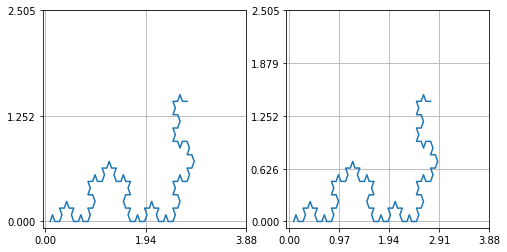

In [ ]:
# Initialize the plot
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(8,4))

def plot_path(ax, x_ticks, y_ticks):
  # Plots each point in the path
  ax.plot(path[:,0], path[:,1])
  # Use the grid segments for the X and Y axis to determine the major axis ticks
  ax.set_yticks(y_ticks)
  ax.set_xticks(x_ticks)
  ax.grid()
  
plot_path(ax1, grid_x, grid_y)
plot_path(ax2, divided_x, divided_y)

### Detecting if a Point Lies Within a Grid Box

1. Create a range to index the X and Y axis grid segments
2. Create a cartesian product of the grid segment ranges so that every X boundary is paired with every Y boundary
3. Grab X and Y box boundaries for each index by retrieving the corresponding grid intercepts along with the preceding intercept
4. Determine if any points fall between these boundaries

In [ ]:
# Create a range of indexes for the grid segments
idx_range = list(range(1, n_divides+1))

# Implements a Cartesian Product of the index range against itself
idxs = list(itertools.product(idx_range,idx_range))

nbox_intercepted = 0
for xi,yi in idxs:
  # Uses the grid indexes to grab box boundaries
  x0,x1 = grid_x[xi-1], grid_x[xi]
  y0,y1 = grid_y[yi-1], grid_y[yi]

  # Filter the path by returning points that fall within both the X and Y boundaries
  inside_box = path[(path[:,0]>x0) & (path[:,0]<x1) & (path[:,1]>y0) & (path[:,1]<y1)]
  if len(inside_box) > 0:
      # If there are points inside the box boundaries, increment the counter
      nbox_intercepted += 1
nbox_intercepted

3

## Refactoring into a Function

In order to calculate the fractal dimension of the path, we need vary the number of boxes that a grid contains and return the number of intercepted boxes.

The function below contains the code above, and allows us to change the number of boxes per grid dynamically.

In [ ]:
def count_intercepts(path, grid_x, grid_y):
  # Create a range of indexes for the grid segments
  idx_range = list(range(1, len(grid_x)))

  # Implements a Cartesian Product of the index range against itself
  idxs = list(itertools.product(idx_range,idx_range))
  points_per_box = []
  nbox_intercepted = 0
  for xi,yi in idxs:
    # Uses the grid indexes to grab box boundaries
    x0,x1 = grid_x[xi-1], grid_x[xi]
    y0,y1 = grid_y[yi-1], grid_y[yi]

    # Filter the path by returning points that fall within both the X and Y boundaries
    points_in_box = path[(path[:,0]>x0) & (path[:,0]<x1) & (path[:,1]>y0) & (path[:,1]<y1)]
    if len(points_in_box) > 0:
        # If there are points inside the box boundaries, increment the counter
        nbox_intercepted += 1
        points_per_box.append(len(points_in_box))
  return nbox_intercepted, np.mean(points_per_box)

Constraints for determining the number of boxes


1.   The number of boxes should be a power of 2
2.   Minimum number of boxes should be 1
3.   Maximum number of boxes should approach the resolution of the data



In [ ]:
def grab_box_counts(path):
  # Initialize arrays where interception box counts and grid size are held
  nbox_intercepted_all = []
  nbox_grid = []

  # Initialize values used in while loop with a 2x2 grid 
  grid_x = np.linspace(0, max(path[:,0])+1,num=3)
  grid_y = np.linspace(0, max(path[:,1])+1,num=3)
  _, points_per_box = count_intercepts(path, grid_x, grid_y)
  
  while  points_per_box > 1.05:
    grid_x, grid_y = divide_segment(grid_x), divide_segment(grid_y)
    nbox_intercepted, points_per_box = count_intercepts(path, grid_x, grid_y)
    
    nbox_intercepted_all.append(nbox_intercepted)
    nbox_grid.append(grid_x[1]-grid_x[0])
  return nbox_intercepted_all[:-1], nbox_grid[:-1]

N, magnification = grab_box_counts(path)
print(N, magnification)

32.333333333333336
16.166666666666668
7.461538461538462
2.6216216216216215
1.1022727272727273
[6, 13, 37, 88] [0.9701646090534983, 0.48508230452674916, 0.24254115226337458, 0.12127057613168729]


In [ ]:
x = [np.log(1/s) for s in magnification]
y = [np.log(n) for n in N]

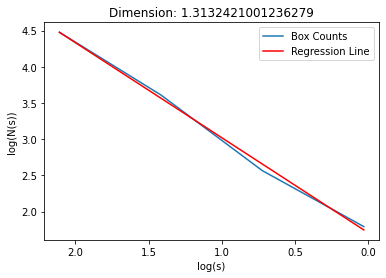

In [ ]:
X = np.array(x).reshape(-1, 1)
lr = LinearRegression(fit_intercept=True)
lr.fit(X,y)
lr.coef_

y_pred = lr.predict(X)

fig, ax = plt.subplots()
ax.plot(x,y, label='Box Counts')
ax.invert_xaxis()
ax.set_xlabel('log(s)')
ax.set_ylabel('log(N(s))');
ax.plot(X,y_pred,c='r', label='Regression Line')
dimension = lr.coef_
ax.set_title(f'Dimension: {dimension[0]}');
ax.legend();